### Business Problem:

---


  Since stack overflow is one of the largest Q&A platforms there are lots of data for every query, this huge amount of information makes it difficult to search for the solution that one is looking for. someone who is new to programing, it is not easy to find optimal answers to their queries when search engine results are based only on words used in search query and not based on semantic similarity.

Search engine which takes minutes to results is also not acceptable, therefore an optimized semantic search engine with scalability is necessary to tackle the problem. Given any query our search engine should return questions and answers related to question that are semantically similar in a small window.



  


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nithishm","key":"5752e97b86624536a004aa37de723519"}'}

In [ ]:
!pip install pyunpack 
!pip install patool

     |████████████████████████████████| 77 kB 2.7 MB/s 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lxml
import re

In [ ]:
#Downloading data from kaggle using kaggle api
!pip install --upgrade --force-reinstall --no-deps kaggle
#Creating folder named kaggle
!mkdir ~/.kaggle
#copying kaggle.json to folder kaggle
!cp kaggle.json ~/.kaggle/
#Modify file permission to the folder
!chmod 600 ~/.kaggle/kaggle.json

     |████████████████████████████████| 58 kB 3.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=a491e6456c64888fea1bef85e9a29ca8c1b26311e92d19a5d977520dfdcf0a9f
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!kaggle datasets download -d stackoverflow/stacksample

100% 1.10G/1.11G [00:09<00:00, 62.7MB/s]
100% 1.11G/1.11G [00:09<00:00, 130MB/s] 


In [ ]:
#unzipping the data from kaggle stackoverflow dataset
from pyunpack import Archive
Archive('/content/stacksample.zip').extractall("")

In [ ]:
answers = pd.read_csv('/content/Answers.csv', encoding = "ISO-8859-1", )
questions = pd.read_csv('/content/Questions.csv', encoding = "ISO-8859-1", )
tags = pd.read_csv('/content/Tags.csv', encoding = "ISO-8859-1", )

In [ ]:
questions = pd.read_csv('/content/Questions.csv', encoding = "ISO-8859-1", )

In [ ]:
questions.head(2)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...


In [ ]:
tags.head(2)

,Id,Tag
0,80,flex
1,80,actionscript-3


In [ ]:
answers.head(2)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26.0,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...


##Data Preprocessing

In [ ]:
#Sorting Dataframe in order of Id
tags.sort_values(by=['Id'], inplace=True,ascending=True)

#concatenating tags attached to the same questions
tag=[]
j=0
for i in tags['Id'].value_counts(sort=False).values:
  i=i+j
  tag.append(tags['Tag'].iloc[j:i].values)
  j=i

#creating a dictionary to store the lists
dict = {'Id':np.unique(tags['Id']),'Tags':tag}

#creating a new DataFrame to store the concatenated tags
concat_tags = pd.DataFrame(dict)

#Merging concat_tags and questions table
questions = pd.merge(questions, concat_tags, on='Id')

In [ ]:
questions.head(2)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Tags
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]"
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]"


In [ ]:
def text_preprocessing(text):


  #Decontractions, replace words like below to full words. 
  text = re.sub(r"n\'t", " not", text)
  text = re.sub(r"\'re", " are", text)
  text = re.sub(r"\'s", " is", text)
  text = re.sub(r"\'d", " would", text)
  text = re.sub(r"\'ll", " will", text)
  text = re.sub(r"\'t", " not", text)
  text = re.sub(r"\'ve", " have", text)
  text = re.sub(r"\'m", " am", text)

  #Removing tags like "< anyword >"
  text = re.sub('\<.*?\>',' ',text)
  #Removing all the newlines('\n'), tabs('\t'), "-"
  text = re.sub('\n|\t|\r|-',' ',text)
  #Removing all the data which are present in the brackets
  text = re.sub('\(.*?\)',' ',text)
  #Removing all the data which are present in the flower brackets
  text = re.sub('\{.*?\}',' ',text)
  #Removing URL's
  text = re.sub(r'http\S+', ' ', text)
  #Removing special characters
  text = re.sub('[?|!|\'|"|#]',' ', text)
  text = re.sub('[.|,|)|(|\|/]',' ', text)
  #Replacing numbers with word counterpart
  #https://stackoverflow.com/questions/22545114/python-regex-sub-use-match-as-dict-key-in-substitution
  num =  {'1':'one', '2':'two', '3':'three', '4':'four', '5':'five', '6':'six', '7':'seven', '8':'eight', '9':'nine', '0':'zero'}
  text = re.sub('[0-9]', lambda m: num.get(m.group()), text)
  #Removing non alphabets
  text = re.sub("[^a-zA-Z]",' ', text)
  #Converting text to lower case
  text = text.lower()
  text = ' '.join(text.split())




  return text


In [ ]:
#tags pre processing
def tags_preprocess(tags):

  tags = ' '.join([str(elem) for elem in tags])

  #https://stackoverflow.com/questions/22545114/python-regex-sub-use-match-as-dict-key-in-substitution
  num =  {'1':'one', '2':'two', '3':'three', '4':'four', '5':'five', '6':'six', '7':'seven', '8':'eight', '9':'nine', '0':'zero'}
  tags = re.sub('[0-9]', lambda m: num.get(m.group()), tags)

  special = {'+':'plus', '-':'dash', '#':'hash', '.':'dot'}
  tags = re.sub(r'[-+#.]', lambda n: special.get(n.group()), tags)


  return tags



In [ ]:
#preprocessing tags
questions['Tags'] =  questions['Tags'].apply(tags_preprocess)

In [ ]:
#perprocesing questions Title
questions['Title'] = questions['Title'].apply(text_preprocessing)

In [ ]:
#perprocesing questions discription
questions['Body'] = questions['Body'].apply(text_preprocessing)

In [ ]:
#perprocesing answers discription
answers['Body'] = answers['Body'].apply(text_preprocessing)

In [ ]:
#Before preprocessing
#questions['Body'][0]

'<p>I\'ve written a database generation script in <a href="http://en.wikipedia.org/wiki/SQL">SQL</a> and want to execute it in my <a href="http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime">Adobe AIR</a> application:</p>\n\n<pre><code>Create Table tRole (\n      roleID integer Primary Key\n      ,roleName varchar(40)\n);\nCreate Table tFile (\n    fileID integer Primary Key\n    ,fileName varchar(50)\n    ,fileDescription varchar(500)\n    ,thumbnailID integer\n    ,fileFormatID integer\n    ,categoryID integer\n    ,isFavorite boolean\n    ,dateAdded date\n    ,globalAccessCount integer\n    ,lastAccessTime date\n    ,downloadComplete boolean\n    ,isNew boolean\n    ,isSpotlight boolean\n    ,duration varchar(30)\n);\nCreate Table tCategory (\n    categoryID integer Primary Key\n    ,categoryName varchar(50)\n    ,parent_categoryID integer\n);\n...\n</code></pre>\n\n<p>I execute this in Adobe AIR using the following methods:</p>\n\n<pre><code>public static function RunSqlFromFile

In [ ]:
#After preprocessing
questions['Body'][0]

' i have written a database generation script in  sql  and want to execute it in my  adobe air  application      create table trole      create table tfile        filedescription varchar       thumbnailid integer      fileformatid integer      categoryid integer      isfavorite boolean      dateadded date      globalaccesscount integer      lastaccesstime date      downloadcomplete boolean      isnew boolean      isspotlight boolean      duration varchar     create table tcategory        parent categoryid integer             i execute this in adobe air using the following methods      public static function runsqlfromfile  void    public static function nonquery  void       catch                no errors are generated  however only  trole  exists  it seems that it only looks at the first query    is there a way to call multiple queries in one statement   '

###Using spell checkers to to correct spellings 

In [ ]:

!pip install pyspellchecker
from spellchecker import SpellChecker
 
spell = SpellChecker()
 
# find those words that may be misspelled
misspelled = spell.unknown(["cmputr", "watr", "study", "wrte"])
 
for word in misspelled:
    # Get the one `most likely` answer
    print(spell.correction(word))
 
    # Get a list of `likely` options
    print(spell.candidates(word))

     |████████████████████████████████| 2.7 MB 7.6 MB/s 
water
{'waar', 'wat', 'wate', 'wanr', 'water', 'watc', 'watt', 'wath', 'wats', 'wart', 'atr', 'war'}
computer
{'compute', 'computer', 'caputo', 'impute', 'caput'}


In [ ]:
spell.unknown(["cmputr", "watr", "study", "wrte"])

{'cmputr', 'watr'}

In [ ]:
string = spell.unknown(("I have written a database generation script in  SQL  and want to execute it in my  Adobe AIR  application      Create Table tRole      Create Table tFile        fileDescription varchar       thumbnailID integer      fileFormatID integer      categoryID integer      isFavorite boolean      dateAdded date      globalAccessCount integer      lastAccessTime date      downloadComplete boolean      isNew boolean      isSpotlight boolean      duration varchar     Create Table tCategory        parent categoryID integer             I execute this in Adobe AIR using the following methods      public static function RunSqlFromFile  void    public static function NonQuery  void       catch                No errors are generated  however only  tRole  exists  It seems that it only looks at the first query    Is there a way to call multiple queries in one statement   ").split())

In [ ]:
#pyspellchecker identifies technical terms as spelling errors and corrects them which is not optimal
string

{'boolean',
 'categoryid',
 'dateadded',
 'downloadcomplete',
 'filedescription',
 'fileformatid',
 'globalaccesscount',
 'isfavorite',
 'isnew',
 'isspotlight',
 'lastaccesstime',
 'nonquery',
 'runsqlfromfile',
 'sql',
 'tcategory',
 'tfile',
 'thumbnailid',
 'trole',
 'varchar'}

In [ ]:
#printing out corrected word with incorretly spelled word
for word in string:
    # Get the one `most likely` answer
    print(word,': ', spell.correction(word))
 

varchar :  archer
tfile :  file
nonquery :  conquer
trole :  role
globalaccesscount :  globalaccesscount
runsqlfromfile :  runsqlfromfile
boolean :  woolen
fileformatid :  fileformatid
downloadcomplete :  downloadcomplete
isspotlight :  spotlight
thumbnailid :  thumbnail
isnew :  sinew
isfavorite :  favorite
tcategory :  category
categoryid :  category
dateadded :  dateadded
filedescription :  filedescription
lastaccesstime :  lastaccesstime
sql :  sol


In [ ]:
#installing jamspell
!apt-get install swig3.0
!pip install jamspell

In [ ]:
#Downloading a language model
!wget https://raw.githubusercontent.com/bakwc/JamSpell-models/master/en.tar.gz

--2022-02-14 08:49:59--  https://raw.githubusercontent.com/bakwc/JamSpell-models/master/en.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36611828 (35M) [application/octet-stream]
Saving to: ‘en.tar.gz’

en.tar.gz           100%[===================>]  34.92M  --.-KB/s    in 0.1s    

2022-02-14 08:50:01 (234 MB/s) - ‘en.tar.gz’ saved [36611828/36611828]



In [ ]:
import tarfile
  
# open file
file = tarfile.open('/content/en.tar.gz')
  
# extracting file
file.extractall('')

In [ ]:
import jamspell
# Create a corrector
corrector = jamspell.TSpellCorrector()
 
# Load Language model -
# argument is a downloaded model file path
corrector.LoadLangModel('/content/en.bin')
 
# To fix text automatically run FixFragment:
print(corrector.FixFragment('I am the begt spell cherken!'))

I am the best spell checker!


In [ ]:
"I have written a database generation script in  SQL  and want to execute it in my  Adobe AIR  application      Create Table tRole      Create Table tFile        fileDescription varchar       thumbnailID integer      fileFormatID integer      categoryID integer      isFavorite boolean      dateAdded date      globalAccessCount integer      lastAccessTime date      downloadComplete boolean      isNew boolean      isSpotlight boolean      duration varchar     Create Table tCategory        parent categoryID integer             I execute this in Adobe AIR using the following methods      public static function RunSqlFromFile  void    public static function NonQuery  void       catch                No errors are generated  however only  tRole  exists  It seems that it only looks at the first query    Is there a way to call multiple queries in one statement   "

'I have written a database generation script in  SQL  and want to execute it in my  Adobe AIR  application      Create Table tRole      Create Table tFile        fileDescription varchar       thumbnailID integer      fileFormatID integer      categoryID integer      isFavorite boolean      dateAdded date      globalAccessCount integer      lastAccessTime date      downloadComplete boolean      isNew boolean      isSpotlight boolean      duration varchar     Create Table tCategory        parent categoryID integer             I execute this in Adobe AIR using the following methods      public static function RunSqlFromFile  void    public static function NonQuery  void       catch                No errors are generated  however only  tRole  exists  It seems that it only looks at the first query    Is there a way to call multiple queries in one statement   '

In [ ]:
#Jamsapell does not perform optimally
corrector.FixFragment("I have written a database generation script in  SQL  and want to execute it in my  Adobe AIR  application      Create Table tRole      Create Table tFile        fileDescription varchar       thumbnailID integer      fileFormatID integer      categoryID integer      isFavorite boolean      dateAdded date      globalAccessCount integer      lastAccessTime date      downloadComplete boolean      isNew boolean      isSpotlight boolean      duration varchar     Create Table tCategory        parent categoryID integer             I execute this in Adobe AIR using the following methods      public static function RunSqlFromFile  void    public static function NonQuery  void       catch                No errors are generated  however only  tRole  exists  It seems that it only looks at the first query    Is there a way to call multiple queries in one statement   ")

'I have written a database generation script in  SQL  and want to execute it in my  Adobe AIR  application      Create Table rOle      Create Table fIle        fileDescription richard       thumbnailID integer      fileFormatID integer      category integer      faVorite boolean      dateAdded date      globalAccessCount integer      lastAccessTime date      downloadComplete boolean      isNer boolean      spOtlight boolean      duration richard     Create Table cAtegory        parent category integer             I execute this in Adobe AIR using the following methods      public static function RunSqlFromFile  void    public static function ConQuer  void       catch                No errors are generated  however only  rOle  exists  It seems that it only looks at the first query    Is there a way to call multiple queries in one statement   '

###EDA

In [ ]:
sum_tags = np.array(tags['Tag'].value_counts())

### Count plot of number of times each tag is used 

' Distribution is heavily skewed where only hundreds of tags are each tagged to lakhs of questions '

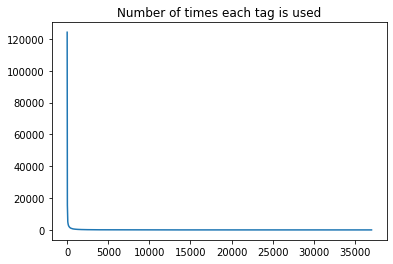

In [ ]:
plt.plot(sum_tags)
plt.title('Number of times each tag is used')
''' Distribution is heavily skewed where only hundreds of tags are each tagged to lakhs of questions '''

 Sum of number of times the first 100 tags are used:  1755529


'hunded most used tags are collectively tagged 1.7 million times'

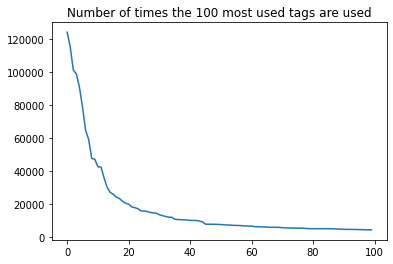

In [ ]:

plt.plot(sum_tags[:100])
plt.title("Number of times the 100 most used tags are used")
print(' Sum of number of times the first 100 tags are used: ',sum(sum_tags[:100]))
'''hunded most used tags are collectively tagged 1.7 million times'''

In [ ]:
#Desending number of times most used 20 tags with their corresponding name to find the distribution of the usage of those tags and thier names
print(tags['Tag'].value_counts()[:20])

'''most used 10 tags are atleast collectively used 1 milion times which might make it difficult to recomend question's when only these tags are used'''

javascript       124155
java             115212
c#               101186
php               98808
android           90659
jquery            78542
python            64601
html              58976
c++               47591
ios               47009
mysql             42464
css               42308
sql               35782
asp.net           29970
objective-c       26922
ruby-on-rails     25789
.net              24059
c                 23238
iphone            21539
angularjs         20345
Name: Tag, dtype: int64


"most used 10 tags are atleast collectively used 1 milion times which might make it difficult to recomend question's when only these tags are used"

'20 thousand tags are each tagged to less than 8 questions if these niche tags are used it will be easier to recomend simillarly tagged questions '

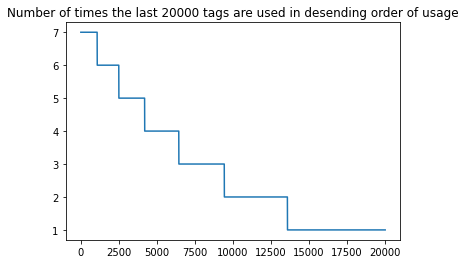

In [ ]:
#Number of times the last 20000 tags are used in desending order of usage
plt.plot(sum_tags[-20000:])
plt.title("Number of times the last 20000 tags are used in desending order of usage")

'''20 thousand tags are each tagged to less than 8 questions if these niche tags are used it will be easier to recomend simillarly tagged questions'''

In [ ]:
print('Number of unique tags: ', len(sum_tags))
print('Number of times every tag is tagged: ', sum(sum_tags))
print('Number of tagged questions: ', len(tags['Id'].unique()))

Number of unique tags:  37034
Number of times every tag is tagged:  3749881
Number of tagged questions:  1264216



  * There are about 1.26 million tagged questions.
  * 37034 unique tags are used 3.7 million times to tag the questions.
  * Out of 37 thousand unique tags 20 of them are collectively tagged 1.2 million times and 100 tags 1.7 million times so we can conclude that tags distribution is highly skewed.
  * 20 thousand tags out of 37 thousand tags are each tagged less than 8 questions.


###Conclusion
*   There are fewer tags used to tag more questions questions which will make it hard to diffrentiate questions if these tags are used.
*   If one of the niche tag from 20 thhousand tag is used it's easty to recomend similar questions



In [ ]:
tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


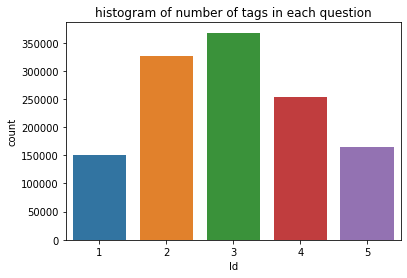

In [ ]:
#histogram of number of tags in each question
sns.countplot(tags['Id'].value_counts())
plt.title('histogram of number of tags in each question')
plt.show()




*   Majority of the questions have more than one tags
*   Number of tags per question follows a normal distribution
*   Maximum number of tags per question is 5





Text(0.5, 1.0, 'CDF of scores')

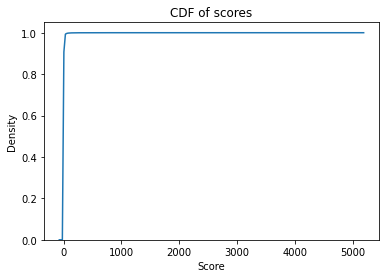

In [ ]:
#CDF of score
sns.kdeplot(questions['Score'], cumulative=True)
plt.title('CDF of scores')

In [ ]:
for i in range(10):
  print((i+1)*10, 'percentile is: ',np.percentile(questions['Score'], (i+1)*10))

10 percentile is:  0.0
20 percentile is:  0.0
30 percentile is:  0.0
40 percentile is:  0.0
50 percentile is:  0.0
60 percentile is:  1.0
70 percentile is:  1.0
80 percentile is:  2.0
90 percentile is:  4.0
100 percentile is:  5190.0


* 50 percent of the points have a score of less than zero
* 80 percent of the questions have a score of less than 3 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count plot of scores less than 10')

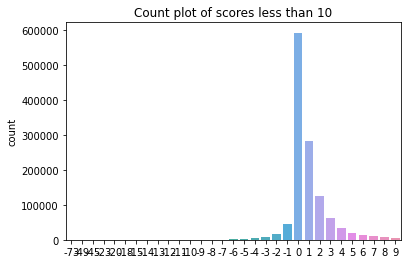

In [ ]:
#Count plot of scores less than 10
sns.countplot(np.array(questions[questions['Score']<10]['Score']))
plt.title('Count plot of scores less than 10')

* The above plot shows number of questions with score less than 10 
* about half the questions in the dataset have a score of 0
* Some questions have scores less than 0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Total number of questions with negative score:  78449


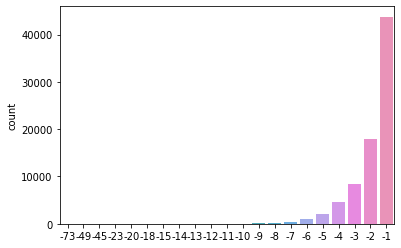

In [ ]:
#Count plot of scores less than 0
sns.countplot(np.array(questions[questions['Score']<0]['Score']))
print('Total number of questions with negative score: ', len(np.array(questions[questions['Score']<0]['Score'])))

* low quality questions might attract downvotes  
* Question with highest down vote is 73
* majority of the questions with negative score has a score of -1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


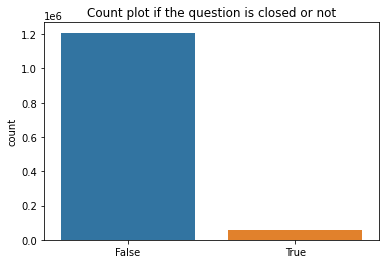

only 4.4263796692970185 % of the questions are marked as closed


In [ ]:
sns.countplot(questions['ClosedDate'].notnull().values)
plt.title('Count plot if the question is closed or not')
plt.show()
print('only',len(questions[questions['ClosedDate'].notnull().values])/(len(questions))*100,'% of the questions are marked as closed')

* Almost 96% of the questions are not marked sloved

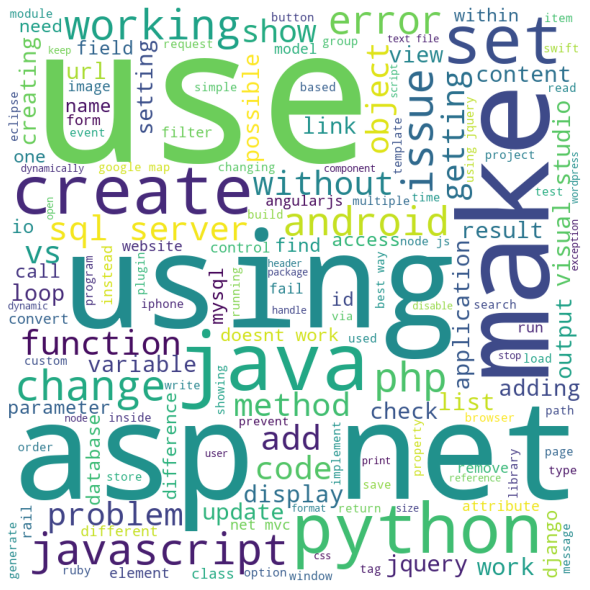

In [ ]:
#Reference https://www.geeksforgeeks.org/generating-word-cloud-python/
#Word Cloud for title
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in questions['Title'].values:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

* words use, using and error are frequently used in title
* Technologies like java, python and net are used frequently which confirms the fact frequently used tags are also the same



Text(0.5, 1.0, 'Distribution of number of words in Body')

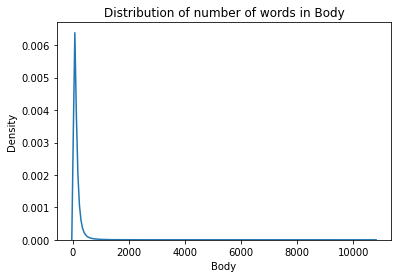

In [ ]:
#Number of words in Body
sns.kdeplot(questions['Body'].apply(lambda x : len (x.split())))
plt.title('Distribution of number of words in Body')

In [ ]:
for i in range(10):
  print((i+1)*10, 'percentile is: ',np.percentile(questions['Body'].apply(lambda x : len (x.split())), (i+1)*10))

10 percentile is:  41.0
20 percentile is:  57.0
30 percentile is:  72.0
40 percentile is:  87.0
50 percentile is:  105.0
60 percentile is:  126.0
70 percentile is:  153.0
80 percentile is:  193.0
90 percentile is:  273.0
100 percentile is:  10793.0


In [ ]:
print('Average words per question is: ' ,sum(questions['Body'].apply(lambda x : len (x.split())))/len(questions))

Average words per question is:  144.31477611420834


In [ ]:
for i in range(11):
  print((i+90), 'percentile is: ',np.percentile(questions['Body'].apply(lambda x : len (x.split())), (i+90)))

90 percentile is:  273.0
91 percentile is:  287.0
92 percentile is:  303.0
93 percentile is:  322.0
94 percentile is:  344.0
95 percentile is:  373.0
96 percentile is:  411.0
97 percentile is:  466.0
98 percentile is:  556.0
99 percentile is:  748.0
100 percentile is:  10793.0


* 80% of the questions have less than 194 words
* Average words per question is about 145
* only the last 5% of the questions have more than 400 words per question

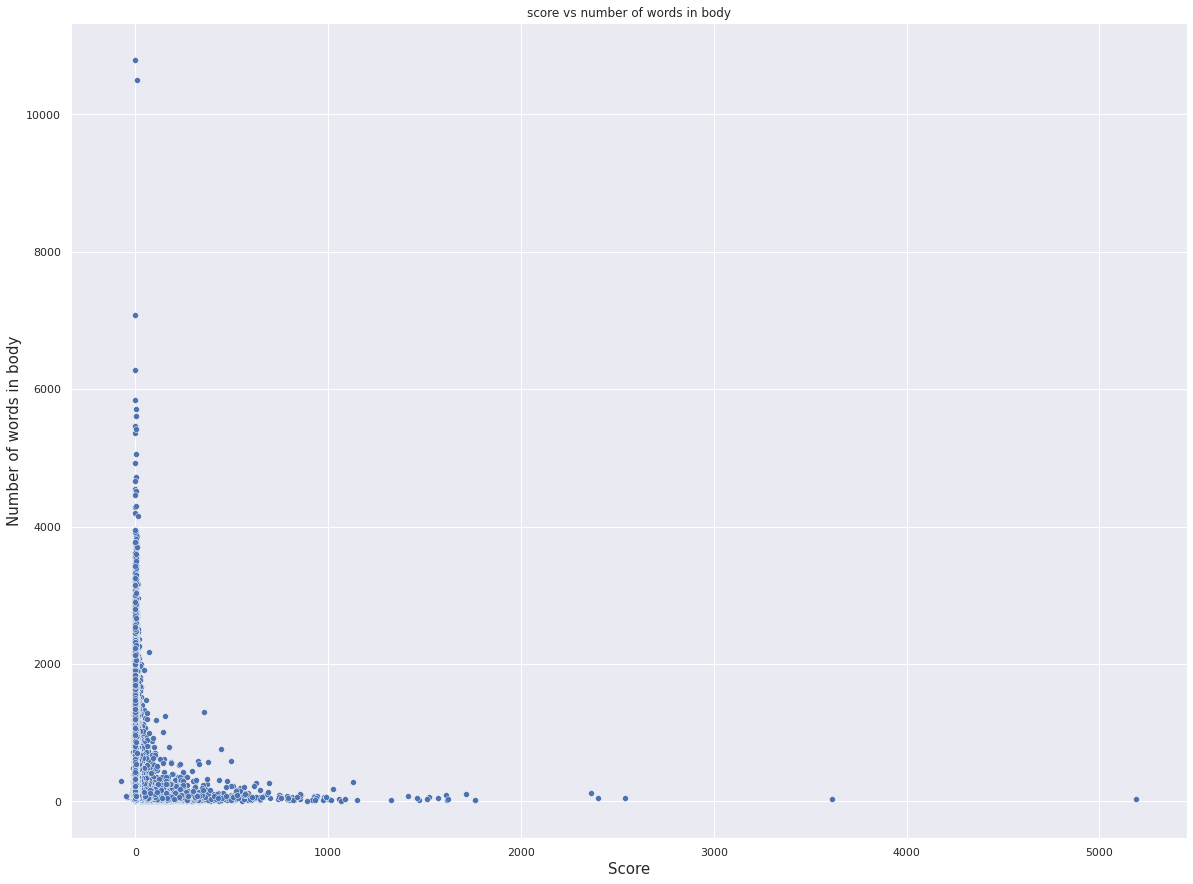

In [ ]:
#Scatter plot of score vs number of words in body
sns.scatterplot(x=questions['Score'], y=questions['Body'].apply(lambda x : len (x.split())))
plt.title('score vs number of words in body')
plt.xlabel("Score", fontsize = 15)
plt.ylabel("Number of words in body", fontsize = 15)
sns.set(rc = {'figure.figsize':(20,15)})

* concise questions with less number of words tend to have higher score's than the longer ones
* There are some outliers which have very large score with less number of words and lower upvotes with higher number of words in their body.
* It's better to recomend questions whith less number words with higher score than the questions with longer body as longer questions doesn't necessarily mean higher score and reduce the size of input vectors to make it computationally efficient.


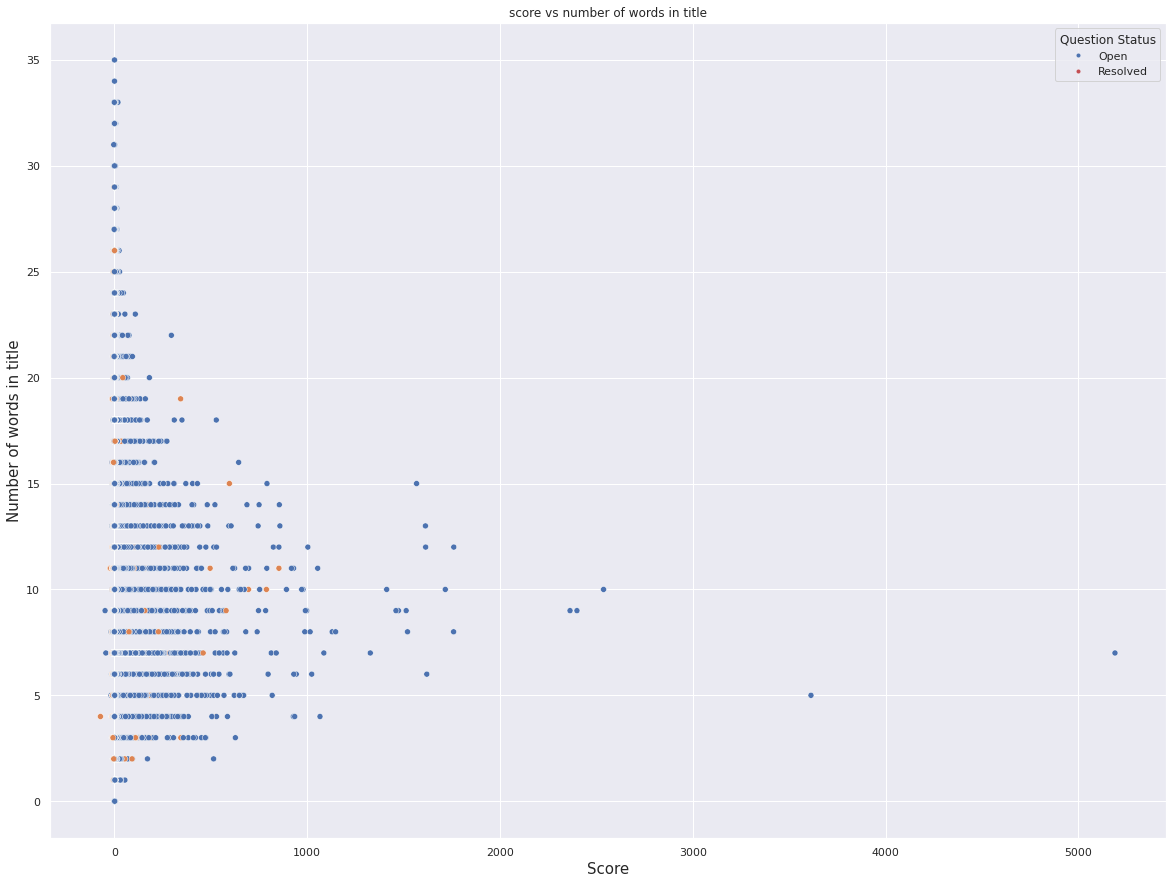

In [ ]:
from seaborn.palettes import color_palette
#Scatter plot of score vs number of words in title
from matplotlib.lines import Line2D
sns.scatterplot(x=questions['Score'], y=questions['Title'].apply(lambda x : len (x.split())), hue= questions['ClosedDate'].notnull().values,legend=False)
plt.title('score vs number of words in title')
plt.xlabel("Score", fontsize = 15)
plt.ylabel("Number of words in title", fontsize = 15)
custom = [Line2D([], [], marker='.', color='b', linestyle='None'),
          Line2D([], [], marker='.', color='r', linestyle='None')]
plt.legend(custom,['Open', 'Resolved'], title='Question Status')
#title='Question Status', labels=
sns.set(rc = {'figure.figsize':(20,15)})


* Questions with smaller title has wide spectrum of scores however as the size of title increases scores tend to decrease
* optimal size with respect to score tend be in the range from 3 words to 15 words any lower or higher scores decrease significantly.
* Status of the question doesn't really impact the scores. 


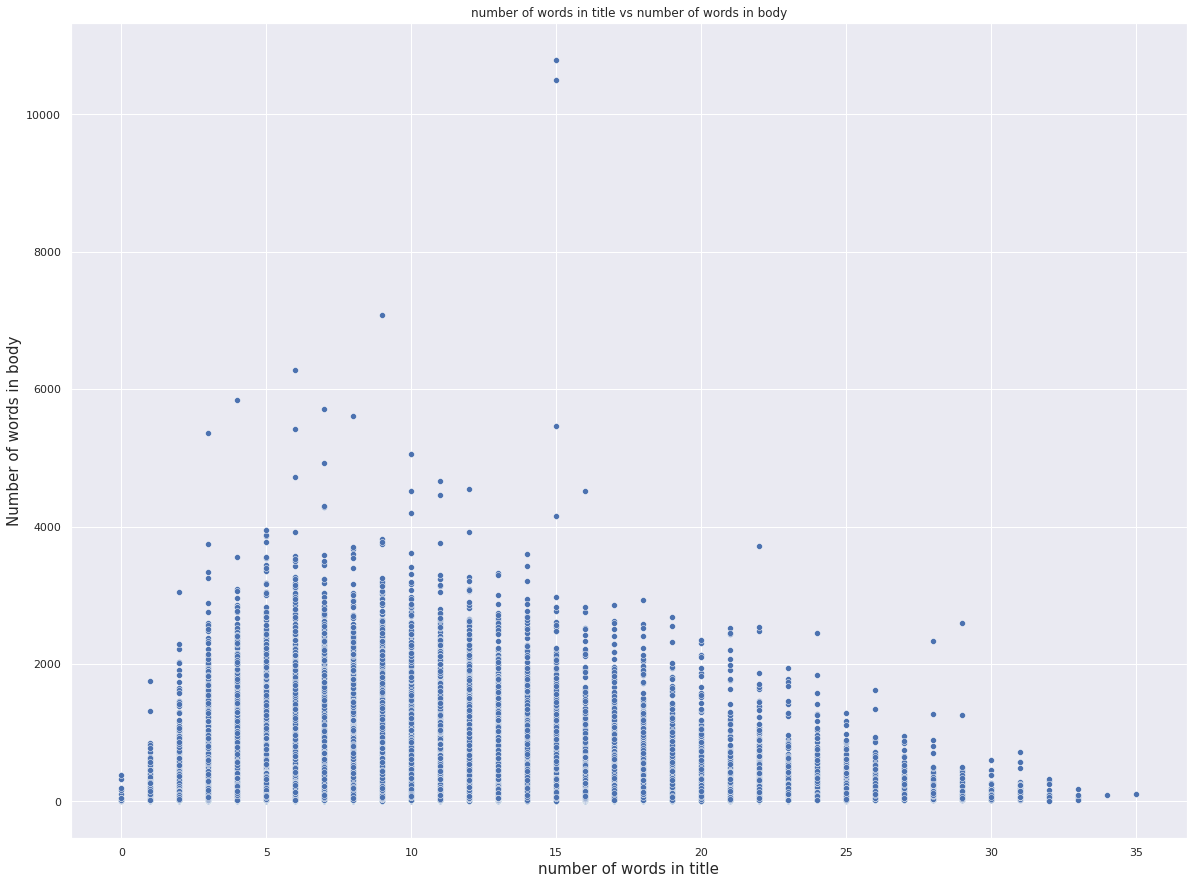

In [ ]:
#Scatter plot of number of words in title vs number of words in body
sns.scatterplot(x=questions['Title'].apply(lambda x : len (x.split())), y=questions['Body'].apply(lambda x : len (x.split())))
plt.title('number of words in title vs number of words in body')
plt.xlabel("number of words in title", fontsize = 15)
plt.ylabel("Number of words in body", fontsize = 15)
sns.set(rc = {'figure.figsize':(17,12)})

* As the title number of words increase above 5 there is a gradual decrese in size of the body  



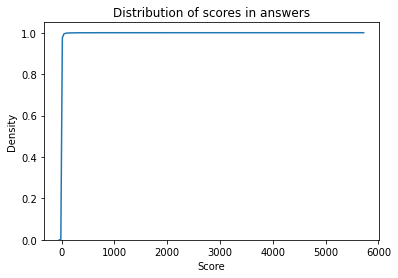

In [ ]:
#PDF of answers scores
sns.kdeplot(answers['Score'], cumulative=True)
plt.title('Distribution of scores in answers')
sns.set(rc = {'figure.figsize':(15,10)})

In [ ]:
for i in range(10):
  print((i+1)*10, 'percentile is: ',np.percentile(answers['Score'], (i+1)*10))

10 percentile is:  0.0
20 percentile is:  0.0
30 percentile is:  0.0
40 percentile is:  0.0
50 percentile is:  1.0
60 percentile is:  1.0
70 percentile is:  2.0
80 percentile is:  3.0
90 percentile is:  4.0
100 percentile is:  5718.0


In [ ]:
for i in range(11):
  print((i+90), 'percentile is: ',np.percentile(answers['Score'], (i+90)))

90 percentile is:  4.0
91 percentile is:  5.0
92 percentile is:  5.0
93 percentile is:  6.0
94 percentile is:  7.0
95 percentile is:  8.0
96 percentile is:  9.0
97 percentile is:  11.0
98 percentile is:  16.0
99 percentile is:  28.0
100 percentile is:  5718.0


* As expected there no negative scores in accepted answers
* close to 50% of the answers have no upvotes
* 90% of the answers have a score of less than 5

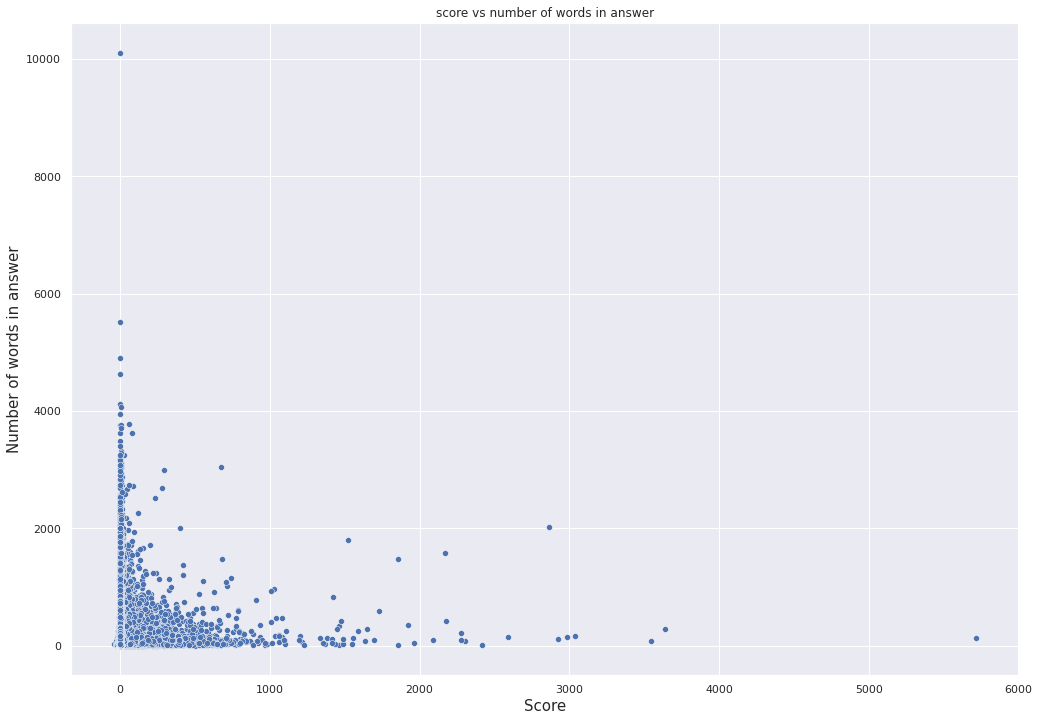

In [ ]:
#Scatter plot of score vs number of words in answer
sns.scatterplot(x=answers['Score'], y=answers['Body'].apply(lambda x : len (x.split())))
plt.title('score vs number of words in answer')
plt.xlabel("Score", fontsize = 15)
plt.ylabel("Number of words in answer", fontsize = 15)
sns.set(rc = {'figure.figsize':(20,15)})

* Distribution is similar to question vs score as number of words in answer increases score dcreases with some outliers.

In [ ]:
questions.drop(columns=['Id','OwnerUserId','CreationDate','ClosedDate'], inplace=True)

In [ ]:
questions.head()

In [ ]:
from google.colab import files

questions.to_csv('questions.csv')
#files.download('questions.csv')

In [ ]:
files.download('questions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import SmoothingFunction

In [ ]:
questions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/semantic search/questions.csv')

In [ ]:
#questions = questions[questions['Title'].notnull()]
#questions = questions[questions['Body'].notnull()]

In [ ]:
#Saving preprocessed data frame
from google.colab import files

questions.to_csv('questions_title.csv')
#files.download('questions.csv')

In [ ]:
#Concatenating body and title
questions['Body'] = questions['Title']+ ' ' + questions['Body']

###Training Doc2Vec with only the title of the question 

In [ ]:
!pip install --upgrade gensim

     |████████████████████████████████| 24.1 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
from gensim.models import Doc2Vec
from gensim.models import KeyedVectors
import gensim
from tqdm import tqdm

In [ ]:
#preparing train data
def read_corpus(corpus, tokens_only=False):
        for i, line in enumerate(corpus):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])



In [ ]:
#Preparing train data
train_corpus = list(read_corpus(questions['Title'].values))

In [ ]:
#Building Doc2Vec model 
model = Doc2Vec(vector_size=100, min_count=1, epochs=100, workers=-1)

In [ ]:
#buliding vocabulary
model.build_vocab(train_corpus)

In [ ]:
#Training model on title
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
#storing vectors of title in a variable from the trained model
docc2vec_title=[]
for doc_id in tqdm(range(len(train_corpus))):
    docc2vec_title.append(model.infer_vector(train_corpus[doc_id].words))

100%|██████████| 1264184/1264184 [52:59<00:00, 397.65it/s]


In [ ]:
#storing computed embeddings
import pickle
with open("doc2vec_title.pkl", "wb") as fp:
  pickle.dump(docc2vec_title, fp)

In [ ]:
#opening saved embeddings
import pickle
a_file = open("/content/drive/MyDrive/Colab Notebooks/semantic search/doc2vec_title.pkl", "rb")
docc2vec_title = pickle.load(a_file)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(a,b):
  sim = cosine_similarity(a,b)
  #print(sim)
  sim = [item for sublist in sim for item in sublist]
  top5 = (np.argsort(sim)[-5:])
  return(top5[::-1])

In [ ]:
def predict(train_vectors, df):
  question = input('Enter your question: ')
  question = question.lower()
  vector = model.infer_vector(question.split())
  similarity = cos_sim(train_vectors, [vector])
  return(df['Title'].iloc[similarity].values)

In [ ]:
predict(docc2vec_title, questions)

Enter your question: how to use multiple queries in sql


array(['select the value of the attribute',
       'webrtc integration in ios with own server',
       'iterating nested list inside out',
       'numberformat exception in android',
       'is it possible to use kafka source in spark streaming without replaying logs from last checkpoint'],
      dtype=object)

In [ ]:
predict(docc2vec_title, questions)

Enter your question: python assertion error


array(['django south remove a specific migration',
       'using jquery ui sortable to sort two list at once',
       'how to call c class method using javascript',
       'php cookie how do i update the value',
       'python smtp init method hangs when used in try except block'],
      dtype=object)

In [ ]:
predict(docc2vec_title, questions)

Enter your question: how to install anaconda


array(['remove dotted line when drawing a transparent',
       'matlab reset vector at index',
       'how to view catalogue of static files on gae control panel',
       'actionbar displays only text',
       'program is saying every number is prime number'], dtype=object)

In [ ]:
predict(docc2vec_title, questions)

Enter your question: how to concatenate two string in java


array(['winpcap how can i get protocol within tcp packet http fields',
       'bufferedwriter not writing all the information',
       'implement stripe payment gateway in cordova phonegap application',
       'panda dataframe conditional mean depending on values in certain column',
       'error saving a file on server'], dtype=object)

In [ ]:
predict(docc2vec_title, questions)

Enter your question: how to setup visual studio


array(['document mode in ieoneone',
       'mysql semicolon placement in procedure',
       'hls aes encrypted video not playing after ext x discontinuity tag on ios',
       'lazy lazy loading error a field initializer cannot reference the non static field method or property',
       'using pjsua for android'], dtype=object)

###Conclusion


> Doc2Vec embeddings with only Title feature doesn't perform well

###Training Doc2Vec with title and body

In [ ]:
!pip install --upgrade gensim

In [ ]:
from gensim.models import Doc2Vec
from gensim.models import KeyedVectors
import gensim
from tqdm import tqdm

In [ ]:
#preparing train data
def read_corpus(corpus, tokens_only=False):
        for i, line in enumerate(corpus):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [ ]:
train_corpus = list(read_corpus(questions['Body'][:300000].values))

In [ ]:
#Building Doc2Vec model 
model = Doc2Vec(vector_size=300, min_count=2, epochs=100, workers=-1)

In [ ]:
#buliding vocabulary
model.build_vocab(train_corpus)

In [ ]:
#Training model on title
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
#storing vectors of title in a variable from the trained model
docc2vec_body=[]
for doc_id in tqdm(range(len(train_corpus))):
    docc2vec_body.append(model.infer_vector(train_corpus[doc_id].words))

100%|██████████| 300000/300000 [1:11:22<00:00, 70.05it/s]


In [ ]:
#storing embeddings
import pickle
with open("doc2vec_body.pkl", "wb") as fp:
  pickle.dump(docc2vec_body, fp)

In [ ]:
#opening saved embeddings
import pickle
a_file = open("/content/drive/MyDrive/Colab Notebooks/semantic search/doc2vec_body.pkl", "rb")
doc2vec_body = pickle.load(a_file)

In [ ]:
#function to calculate cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(a,b):
  sim = cosine_similarity(a,b)
  #print(sim)
  sim = [item for sublist in sim for item in sublist]
  top5 = (np.argsort(sim)[-5:])
  return(top5[::-1])

In [ ]:
#function to predict similar questions
def predict(train_vectors, df):
  question = input('Enter your question: ')
  question = question.lower()
  vector = model.infer_vector(question.split())
  similarity = cos_sim(train_vectors, [vector])
  return(df['Title'].iloc[similarity].values)

In [ ]:
predict(doc2vec_body, questions)

Enter your question: how to use multiple queries in sql


array(['better webforms inspired by asp net mvc',
       'pass option containing comma to configure script',
       'can css be used for alternate fonts', 'tar blocksize message',
       'disable printscreen by jquery or js'], dtype=object)

In [ ]:
predict(doc2vec_body, questions)

Enter your question: python assertion error


array(['memory problem when creating large access reports',
       'using joins in ruby on rails three', 'group records on key',
       'magento add relationship between order model and custom module model with database constraint',
       'deployment time of ear annoying using jboss ant jsp is and prehistoric pc'],
      dtype=object)

In [ ]:
predict(doc2vec_body, questions)

Enter your question:  how to install anaconda


array(['when are you using too much ajax',
       'how to add three condition at jquery',
       'problems doing ajax requests with a phonegap application',
       'starting multiple threads and keeping track of them from my net application',
       'unsigned char array to hex representation nsstring'], dtype=object)

In [ ]:
predict(doc2vec_body, questions)

Enter your question:  how to concatenate two string in java


array(['is it possible to load dynamically a phase listener with jsf one two',
       'getting mouse position with javascript within canvas',
       'fastest way to escape a string in javame',
       'why would my java program send multicast packets with a ttl of one',
       'tokenize text into type string pairs'], dtype=object)

In [ ]:
predict(doc2vec_body, questions)

Enter your question: how to setup visual studio


array(['create new named instance of sql server twozerozeroeight rtwo',
       'how to find out which ansi c standard my gcc works with by default',
       'matlab question on multidimensional files',
       'how to open an existing project in net c in visual studio twozerozeroeight',
       'what is the best way to compile jtwome and jtwose apps from the same codebase'],
      dtype=object)

###Conclusion


> Doc2Vec embeddings with only Title and body feature doesn't perform well

###Training Word2Vec with only the Title of the question

In [ ]:
!pip install --upgrade gensim

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [ ]:
#Title split for training
title_train = questions['Title'].apply(lambda x :str(x).split()) 

In [ ]:
#Training Word2Vec model with Title
model = Word2Vec(title_train, vector_size=100, epochs=100, workers=-1, min_count=1)

In [ ]:
#storing vocabulary in a variable
vocabulary = model.wv.index_to_key

In [ ]:
print('vocab size: ',len(model.wv.index_to_key))

vocab size:  135412


In [ ]:
print(model)

Word2Vec(vocab=135412, vector_size=100, alpha=0.025)


In [ ]:
#Storing word vector pair in a variable
word_vectors = model.wv

word_vectors.save('vectors.kv')
#reloaded_word_vectors = KeyedVectors.load('vectors.kv')

In [ ]:
'''#Computing similarity score and returning similar questions
def distance(corpus, question):
  distance=[]
  for i in corpus:
    distance.append(word_vectors.wmdistance(i,question))
  np.argsort(distance)[:5]
  return distance'''

In [ ]:
#traininig TfIdf on the title
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer()
tfidf_model.fit(questions['Title'].astype('U'))
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#Function to calculate average word2vec using tifidf score of the traning corpus
from tqdm import tqdm
def TfIdf_Word2Vec(x, vocabulary): # compute average word2vec for each review.
  tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(x): # for each review/sentence
      vector = np.zeros(100) # as word vectors are of zero length
      tf_idf_weight =0; # num of words with a valid vector in the sentence/review
      for word in str(sentence).split(): # for each word in a review/sentence
          if (word in vocabulary) and (word in tfidf_words):
              vec = model.wv[word] # getting the vector for each word
              # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
              if type(word)!=str:
                print(word)
              tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
              vector += (vec * tf_idf) # calculating tfidf weighted w2v
              tf_idf_weight += tf_idf
      if tf_idf_weight != 0:
         vector /= tf_idf_weight
      tfidf_w2v_vectors.append(vector)
  return tfidf_w2v_vectors

In [ ]:
avg_title_w2v = TfIdf_Word2Vec(questions['Title'].values, vocabulary)

In [ ]:
import pickle
with open("avg_title_w2v.pkl", "wb") as fp:
  pickle.dump(avg_title_w2v, fp)

In [ ]:
#opening saved embeddings
import pickle
a_file = open("/content/drive/MyDrive/Colab Notebooks/semantic search/avg_title_w2v.pkl", "rb")
avg_title_w2v = pickle.load(a_file)

In [ ]:
#Function to calculate cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(a,b):
  sim = cosine_similarity(a,b)
  #print(sim)
  sim = [item for sublist in sim for item in sublist]
  top5 = (np.argsort(sim)[-5:])
  return(top5[::-1])
  #return(sim)

In [ ]:
#function to predict similar questions
def predict(avg_title_w2v, vocabulary, df):
  question = input('Enter your question: ')
  question = question.lower()
  vector = question_Word2Vec(question, vocabulary)
  similarity = cos_sim(avg_title_w2v, [vector])
  return(df['Title'].iloc[similarity].values)

In [ ]:
predict(avg_title_w2v, vocabulary, questions)

Enter your question: how to use multiple queries in sql


array(['how to do multiple queries to sql',
       'how to sum multiple sql queries together',
       'sql queries from multiple tables',
       'how do i combine multiple sql queries',
       'storing date calculations in sql for use in sql queries'],
      dtype=object)

In [ ]:
predict(avg_title_w2v, vocabulary, questions)

Enter your question: python assertion error


array(['python sqlitethree assertion error', 'assertion error in mongodb',
       'opencv c error assertion failed', 'opencv error assertion failed',
       'opencv error assertion failed'], dtype=object)

In [ ]:
predict(avg_title_w2v, vocabulary, questions)

Enter your question: how to install anaconda


array(['unable to install modules for anaconda',
       'how to install anaconda python for all users',
       'unable to install threading with anaconda sixfour bit',
       'how to install nltk contrib in anaconda',
       'is anaconda for fedora different from anaconda for python'],
      dtype=object)

In [ ]:
predict(avg_title_w2v, vocabulary, questions)

Enter your question: how to concatenate two string in java


array(['concatenate string in swift',
       'concatenate string in java arraylist',
       'how to concatenate strings in java',
       'concatenate to string in rails form',
       'how do i concatenate a string literal and a string variable in java'],
      dtype=object)

In [ ]:
predict(avg_title_w2v, vocabulary, questions)

Enter your question: how to setup visual studio


array(['how to add application setup file to visual studio twozeroonezero setup',
       'visual studio tdd setup', 'microsoft visual studio c setup',
       'how to setup android ios and visual studio with xamarin studio',
       'visual studio setup project freezes'], dtype=object)

### Conclusion 
Avg W2V with Title performed better than doc2vec

###Word2Vec embeddings with Title and Body

In [ ]:
!pip install --upgrade gensim

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [ ]:
#Title with body split for training
body_train = questions['Body'][:400000].apply(lambda x :str(x).split()) 

In [ ]:
#Training Word2Vec model with Title and body
model = Word2Vec(body_train, vector_size=300, epochs=50, workers=-1, min_count=2)

In [ ]:
#storing vocabulary in a variable
vocabulary = model.wv.index_to_key

In [ ]:
print(model)

Word2Vec(vocab=323229, vector_size=300, alpha=0.025)


In [ ]:
#traininig TfIdf on the title amd body
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer()
tfidf_model.fit(questions['Body'].astype('U'))
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#Function to calculate average word2vec using tifidf score of the traning corpus
from tqdm import tqdm
def TfIdf_Word2Vec(x, vocabulary): # compute average word2vec for each review.
  tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(x): # for each review/sentence
      vector = np.zeros(300) # as word vectors are of zero length
      tf_idf_weight =0; # num of words with a valid vector in the sentence/review
      for word in str(sentence).split(): # for each word in a review/sentence
          if (word in vocabulary) and (word in tfidf_words):
              vec = model.wv[word] # getting the vector for each word
              # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
              if type(word)!=str:
                print(word)
              tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
              vector += (vec * tf_idf) # calculating tfidf weighted w2v
              tf_idf_weight += tf_idf
      if tf_idf_weight != 0:
         vector /= tf_idf_weight
      tfidf_w2v_vectors.append(vector)
  return tfidf_w2v_vectors

In [ ]:
#Storing avereage W2V for 2million records
avg_body_w2v = TfIdf_Word2Vec(questions['Body'][:200000].values, vocabulary)

100%|██████████| 200000/200000 [3:08:11<00:00, 17.71it/s]


In [ ]:
import pickle
with open("avg_body_w2v.pkl", "wb") as fp:
  pickle.dump(avg_body_w2v, fp)

In [ ]:
from google.colab import files
files.download('avg_body_w2v')

In [ ]:
#opening saved embeddings
import pickle
a_file = open("/content/drive/MyDrive/Colab Notebooks/semantic search/avg_body_w2v.pkl", "rb")
avg_body_w2v = pickle.load(a_file)

In [ ]:
#Function to calculate average word2vec using tifidf score of the question
def question_b_Word2Vec(x, vocabulary): # compute average word2vec for each review.
  vector = np.zeros(300) # as word vectors are of zero length
  tf_idf_weight =0; # num of words with a valid vector in the sentence/review
  for word in str(x).split(): # for each word in a review/sentence
      #print(word)
      if (word in vocabulary) and (word in tfidf_words):
          vec = model.wv[word] # getting the vector for each word
          # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
          tf_idf = dictionary[word]*(x.count(word)/len(x.split())) # getting the tfidf value for each word
          vector += (vec * tf_idf) # calculating tfidf weighted w2v
          tf_idf_weight += tf_idf
  if tf_idf_weight != 0:
      vector /= tf_idf_weight
  return vector

In [ ]:
#Function to calculate cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(a,b):
  sim = cosine_similarity(a,b)
  #print(sim)
  sim = [item for sublist in sim for item in sublist]
  top5 = (np.argsort(sim)[-5:])
  return(top5[::-1])

In [ ]:
#function to predict similar questions
def predict(avg_title_w2v, vocabulary, df):
  question = input('Enter your question: ')
  question = question.lower()
  vector = question_b_Word2Vec(question, vocabulary)
  similarity = cos_sim(avg_title_w2v, [vector])
  return(df['Title'].iloc[similarity].values)

In [ ]:
predict(avg_body_w2v, vocabulary, questions)

Enter your question: how to use multiple queries in sql


array(['what is the standard python module for sql queries',
       'when to use sql sub queries versus a standard join',
       'query priority in sqlite',
       'help finding old sql tool that rewrote queries',
       'optimzing tsql code'], dtype=object)

In [ ]:
predict(avg_body_w2v, vocabulary, questions)

Enter your question: python assertion error


array(['assertion fails exceptions for stl',
       'unable to set ipython to use two six one python',
       'equivalent to in negative look behind assertion regex python',
       'python equivalent of short form if in c',
       'what version of python should i use if i am a new to python'],
      dtype=object)

In [ ]:
predict(avg_body_w2v, vocabulary, questions)

Enter your question: how to install anaconda


array(['where does easy install install things',
       'rubygems auto install from source code',
       'visual studio twozerozeroeight install using an iso',
       'customising install location for django',
       'find android application install dir'], dtype=object)

In [ ]:
predict(avg_body_w2v, vocabulary, questions)

Enter your question: how to concatenate two string in java


array(['how do you concatenate two strings',
       'concatenate all list content in one string in c',
       'concatenating string in classic asp',
       'what is an efficient way to concatenate all strings in an array separating with a space',
       'what is the fastest way to concatenate two strings in java'],
      dtype=object)

In [ ]:
predict(avg_body_w2v, vocabulary, questions)

Enter your question: how to setup visual studio


array(['opening visual studio twozeroonezero solution files in visual studio twozerozeroeight',
       'visual studio twozeroonezero debugging event',
       'visual studio on a mac',
       'how to build qt for visual studio twozeroonezero',
       'how to tell visual studio that i have installed visual c too'],
      dtype=object)

In [ ]:
#printing top 10 similar questions based on cosine similarity
questions['Title'].iloc[similar].values

array(['what is the standard python module for sql queries',
       'when to use sql sub queries versus a standard join',
       'query priority in sqlite',
       'help finding old sql tool that rewrote queries',
       'optimzing tsql code', 'ruby externalized sql module',
       'measure time of a function with arguments in python',
       'sharing common sql queries amongst a team',
       'how to show sql queries run in the rails console',
       'custom control with custom collection property'], dtype=object)

In [ ]:
#printing top 10 similar questions based on cosine similarity
questions['Title'].iloc[similar].values

array(['what is the standard python module for sql queries',
       'when to use sql sub queries versus a standard join',
       'query priority in sqlite',
       'help finding old sql tool that rewrote queries',
       'optimzing tsql code', 'ruby externalized sql module',
       'measure time of a function with arguments in python',
       'sharing common sql queries amongst a team',
       'how to show sql queries run in the rails console',
       'custom control with custom collection property'], dtype=object)

### Conclusion 
Avg W2V with Title and body performed better than doc2vec

##Creating Embeddings from pre-trained glove embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


In [ ]:
!unzip -q /content/glove.6B.zip

replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import tensorflow as tf

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(questions['Body'])
tokens = tokenizer.texts_to_sequences(questions['Body'])

In [ ]:
#Vocabsize
len(tokenizer.word_index.items())

1990867

In [ ]:
tokenizer.word_index.items()

In [ ]:
import numpy as np
vocab_size = len(tokenizer.word_index) + 1
# load the whole embedding into memory
embeddings_train_index = {}
#with open('/content/glove.42B.300d.txt') as f:
with open('/content/glove.6B.100d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    #print(values[1:])
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_train_index[word] = coefs
  f.close()


In [ ]:
# create a weight matrix for words in training docs
embedding_train_matrix = np.zeros((vocab_size, 100))
num_words=0
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_train_index.get(word)
  if embedding_vector is not None:
    embedding_train_matrix[i] = embedding_vector
    num_words+= 1

###out of 2 million words only 96k is present in glove model 

In [ ]:
embedding_train_matrix.shape

(1990868, 100)

###Creating BERT embeddings from title

In [2]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

     |████████████████████████████████| 79 kB 5.7 MB/s 
     |████████████████████████████████| 3.5 MB 73.9 MB/s 
     |████████████████████████████████| 1.2 MB 32.1 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 6.5 MB 59.1 MB/s 
     |████████████████████████████████| 596 kB 70.8 MB/s 
     |████████████████████████████████| 895 kB 72.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=ba6d26920120be133a09d48701de1eb43400060593e1218e98887e6548080a8d
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#Downloading BERT pretrained on stackoverflow data from Hugging face
transformer = SentenceTransformer('flax-sentence-embeddings/stackoverflow_mpnet-base')

In [ ]:
#Storing embeddings
title_embeddings = Sentence_Embeddings(questions['Title'][900000:].values)

In [ ]:
import pickle
a_file = open("/content/drive/MyDrive/Colab Notebooks/semantic search/BERT_title_embeddings.pkl", "rb")
bert_title_embeddings = pickle.load(a_file)
a_file.close()

In [ ]:
len(bert_title_embeddings)

1264184

In [ ]:
import pickle
a_file = open("/content/drive/MyDrive/Colab Notebooks/semantic search/mpnet_base.pkl", "rb")
model = pickle.load(a_file)
a_file.close()

In [ ]:
#Function to calculate sentence embeddings of question title
from tqdm import tqdm
def Sentence_Embeddings(data):
  embeddings = []
  for i in tqdm(data):
    embeddings.append(model.encode(i))
  return embeddings


In [ ]:
#function to predict similar questions
def predict(title_embeddings, df):
  question = input('Enter your question: ')
  question = question.lower()
  question_embedd = Sentence_Embeddings([question])
  similarity = cos_sim(title_embeddings, question_embedd)
  #return(similarity)
  return(df['Title'].iloc[similarity].values)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#Function to calculate cosine similarity
def cos_sim(a,b):
  sim = cosine_similarity(a,b)
  #print(sim.shape)
  top5 = (np.argsort(sim)[0][-5:])
  return(top5[::-1])
  #return(sim)

In [ ]:
def cosine_sim(title_embeddings, question):
  #sim=np.array([])
  sim=[]
  for i in tqdm(title_embeddings):
    #cos_sim = dot(question, i)/(norm(question)*norm(i))
    sim.extend(np.dot(question, i)/(norm(question)*norm(i)))
    #sim.extend(cos_sim)
    #np.append(sim,np.array(cos_sim))
  top5 = (np.argsort(sim)[-5:])
  return top5

In [ ]:
predict(bert_title_embeddings, questions)

Enter your question: how to use multiple queries in sql


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


In [ ]:
predict(embeddings_combined[:], questions)

Enter your question: how to use multiple queries in sql


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


array(['how do i combine multiple sql queries',
       'two sql queries from same table', 'combine three sql queries',
       'query with multiple select statements', 'mysql multiple queries'],
      dtype=object)

In [ ]:
predict(title_embeddings, questions)

Enter your question: how to install anaconda


array(['how to install python on mac os x and windows with aptana studio',
       'error installing python',
       'how to install a python package to windows',
       'how do i install modules in python on windows',
       'easy install with various versions of python installed mac osx'],
      dtype=object)

In [ ]:
predict(embeddings_combined[:], questions)

Enter your question: how to install anaconda


100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


array(['installing anaconda to use with windows',
       'how to install anaconda python for all users',
       'after anaconda installation conda command fails with importerror no module named conda cli',
       'how to determine anaconda is fully installed on mac',
       'error installing ta lib for anaconda'], dtype=object)

In [ ]:
predict(title_embeddings, questions)

Enter your question: how to concatenate two string in java


array(['java concatenate two strings error',
       'what is the fastest way to concatenate two strings in java',
       'how do you concatenate two strings',
       'how do i concatenate a string literal and a string variable in java',
       'how to append two string'], dtype=object)

In [ ]:
predict(embeddings_combined[:], questions)

Enter your question: how to concatenate two string in java


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


array(['concatenation of two java strings',
       'java concatenate two strings error',
       'how to concatenate parts of strings in java',
       'how to concatenate two dimensional arrays of string in java',
       'java string concatenation and system out println doesnt work'],
      dtype=object)

In [ ]:
predict(title_embeddings, questions)

Enter your question: how to setup visual studio


array(['development of visual studio ide', 'visual studio on mac os x',
       'how to tell visual studio that i have installed visual c too',
       'create new visual studio project add files and run it command line',
       'how to use visual studio for wordpress development'], dtype=object)

In [ ]:
predict(embeddings_combined[:], questions)

Enter your question: how to setup visual studio


100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


array(['configurations of visual studio', 'visual studio programming',
       'installing application created on visual studio',
       'where to download visual studio full version',
       'program wo not start without a visual studio installation'],
      dtype=object)

### Conclusion 
BERT embeddings with Title performed better than other embeddings

##BERT embeddings with Title and Body

In [ ]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

     |████████████████████████████████| 79 kB 3.5 MB/s 
     |████████████████████████████████| 3.5 MB 11.8 MB/s 
     |████████████████████████████████| 1.2 MB 8.5 MB/s 
     |████████████████████████████████| 67 kB 4.1 MB/s 
     |████████████████████████████████| 596 kB 36.6 MB/s 
     |████████████████████████████████| 895 kB 23.7 MB/s 
     |████████████████████████████████| 6.8 MB 7.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=f6be1be676435996fe480d72161ed23342ae48921d1e6d5d1dfdb05fea38fd9c
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#Downloading BERT pretrained on stackoverflow data from Hugging face
transformer = SentenceTransformer('flax-sentence-embeddings/stackoverflow_mpnet-base')

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/133 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#Function to calculate sentence embeddings of question title
from tqdm import tqdm
def Sentence_Embeddings(data):
  embeddings = []
  for i in tqdm(data):
    embeddings.append(transformer.encode(i))
  return embeddings

In [ ]:
#Storing embeddings
embeddings = Sentence_Embeddings(questions['Body'].values)

In [ ]:
#Storing title embeddings as pickle file
import pickle
afile = open("embeddings.pkl", "wb")
pickle.dump(embeddings, afile )
afile.close()

In [ ]:
#opening saved embeddings
import pickle
a_file = open("/content/drive/MyDrive/Colab Notebooks/semantic search/body_embedding.pkl", "rb")
body_embeddings = pickle.load(a_file)

In [ ]:
#Function to calculate cosine similarity
def cos_sim(a,b):
  sim = cosine_similarity(a,b)
  top5 = (np.argsort(sim)[0][-5:])
  return(top5[::-1])
  #return(sim)

In [ ]:
#function to predict similar questions
def predict(body_embeddings, df):
  question = input('Enter your question: ')
  question = question.lower()
  question_embedd = Sentence_Embeddings([question])
  similarity = cos_sim(question_embedd, body_embeddings)
  #return(similarity)
  return(df['Title'].iloc[similarity].values)

In [ ]:
predict(body_embeddings, questions)

Enter your question: how to use multiple queries in sql


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


array(['single sql query for retrieval of data with different where clause possible',
       'select command sql more than one value',
       'how do i combine multiple sql queries',
       'how to launch two sql queries using result of first one in second',
       'getting multiple variables to show up in sql server'],
      dtype=object)

In [ ]:
predict(body_embeddings, questions)

Enter your question: python assertion error


100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


array(['python programming help', 'assertrises failure',
       'python multiprocessing pool assertion error in interpreter',
       'indentationerror expected an indented block',
       'python class object initialization within function'], dtype=object)

In [ ]:
predict(body_embeddings, questions)

Enter your question: how to install anaconda


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


array(['how do i install modules in python on windows',
       'installing the newest scipy in ubuntu',
       'need help installing biopython',
       'how to install python on mac os x and windows with aptana studio',
       'google python gdata library installation failing'], dtype=object)

In [ ]:
predict(body_embeddings, questions)

Enter your question: how to concatenate two string in java


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


array(['java concatenate two strings error', 'how to append two string',
       'how do i concatenate a string literal and a string variable in java',
       'concatenate integer values separated by pipe and using java',
       'in android how to concatenate basesixfour encoded strings'],
      dtype=object)

In [ ]:
predict(body_embeddings, questions)

Enter your question: how to setup visual studio


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


array(['how to tell visual studio that i have installed visual c too',
       'microsoft visual c twozeroonezero express installation run problems',
       'visual studio on a mac', 'how to create setup files in c',
       'change default visual studio command prompt location'],
      dtype=object)

###Conclusion


> Due to compute constrains only portion of data is used to train and create embeddings with title+body

> Since only portion of the data is used BERT embeddings created on title performed better than other embeddings





###Pipeline


In [48]:

class BERT:

  def __init__(self, title_embeddings, model, df):
    self.title_embeddings = title_embeddings
    self.model = model
    self.df = df
    

  def preprocessing(self,text):

    #Decontractions, replace words like below to full words. 
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    #Removing tags like "< anyword >"
    #text = re.sub('\<.*?\>',' ',text)
    #Removing all the newlines('\n'), tabs('\t'), "-"
    #text = re.sub('\n|\t|\r|-',' ',text)
    #Removing all the data which are present in the brackets
    text = re.sub('\(.*?\)',' ',text)
    #Removing all the data which are present in the flower brackets
    text = re.sub('\{.*?\}',' ',text)
    #Removing URL's
    text = re.sub(r'http\S+', ' ', text)
    #Removing special characters
    text = re.sub('[?|!|\'|"|#]',' ', text)
    text = re.sub('[.|,|)|(|\|/]',' ', text)
    #Replacing numbers with word counterpart
    #https://stackoverflow.com/questions/22545114/python-regex-sub-use-match-as-dict-key-in-substitution
    num =  {'1':'one', '2':'two', '3':'three', '4':'four', '5':'five', '6':'six', '7':'seven', '8':'eight', '9':'nine', '0':'zero'}
    text = re.sub('[0-9]', lambda m: num.get(m.group()), text)
    #Removing non alphabets
    text = re.sub("[^a-zA-Z]",' ', text)
    #Converting text to lower case
    text = text.lower()
    text = ' '.join(text.split())

    return text


  #Function to calculate sentence embeddings of question title
  def Sentence_Embeddings(self,data, model):
    embeddings = []
    for i in tqdm(data):
      embeddings.append(model.encode(i))
    return embeddings


  #Function to calculate cosine similarity
  def cos_sim(self,a,b):
    sim = cosine_similarity(a,b)
    sim = [item for sublist in sim for item in sublist]
    #top5 = (np.argsort(sim)[-5:])
    return(sim)



  #function to predict similar questions
  def predict(self):
    question= input('Enter your question: ')
    question = self.preprocessing(question)
    question_embedd = self.Sentence_Embeddings([question], self.model)
    similarity=[]
    #sending in batches to moderate memory usage
    #similarity.extend(self.cos_sim(self.title_embeddings[:400000], question_embedd))
    #similarity.extend(self.cos_sim(self.title_embeddings[400000:800000], question_embedd))
    #similarity.extend(self.cos_sim(self.title_embeddings[800000:], question_embedd))
    similarity=self.cos_sim(self.title_embeddings[:], question_embedd)
    #return similarity
    top5 = (np.argsort(similarity)[-5:][::-1])
    return(self.df['Title'].iloc[top5].values)


In [3]:
#loading model from a pickle file
import pickle
a_file = open("/content/drive/MyDrive/Colab Notebooks/semantic search/mpnet_base.pkl", "rb")
bert_model = pickle.load(a_file)
a_file.close()

In [4]:
#loading embeddings from a pickle file
import pickle
a_file = open("/content/drive/MyDrive/Colab Notebooks/semantic search/BERT_title_embeddings.pkl", "rb")
bert_title_embeddings = pickle.load(a_file)
a_file.close()

In [37]:
from tqdm import tqdm

In [6]:
questions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/semantic search/questions_title.csv')

In [49]:
model = BERT(bert_title_embeddings, bert_model, questions)

In [44]:
model.predict()

Enter your question: data preprocessing


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


array(['preprocess data for reporting',
       'regarding creating a data set in accordance with a given data format',
       'data extraction and transform efficiency',
       'data processing puzzle headache',
       'how do i categorize my data for a datamining procedure'],
      dtype=object)

In [46]:
model.predict()

Enter your question: data


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


array(['the correct definition of data', 'how to get data correctly',
       'data deduplificaton', 'how do i get the data',
       'data saving and data reading'], dtype=object)